In [5]:

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


train = pd.read_parquet('/content/drive/MyDrive/DRW Crypto Market Prediction/train.parquet', engine='pyarrow')
test = pd.read_parquet('/content/drive/MyDrive/DRW Crypto Market Prediction/test.parquet', engine='pyarrow')
sample_sub = pd.read_csv('/content/drive/MyDrive/DRW Crypto Market Prediction/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Check GPU availability
import torch
if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from Google Drive...
Data loaded successfully!
Train shape: (525886, 786)
Test shape: (538150, 786)
GPU available: Tesla T4


In [6]:
# Identify feature columns (exclude known market features and label)
market_cols = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
feature_cols = [col for col in train.columns if col.startswith('X')]

Calculating correlation matrix for ALL features...
Processing 780 features...
Computing correlations with progress...


Processing features: 100%|██████████| 780/780 [23:35<00:00,  1.82s/it]


Correlation calculation took 1416.99 seconds


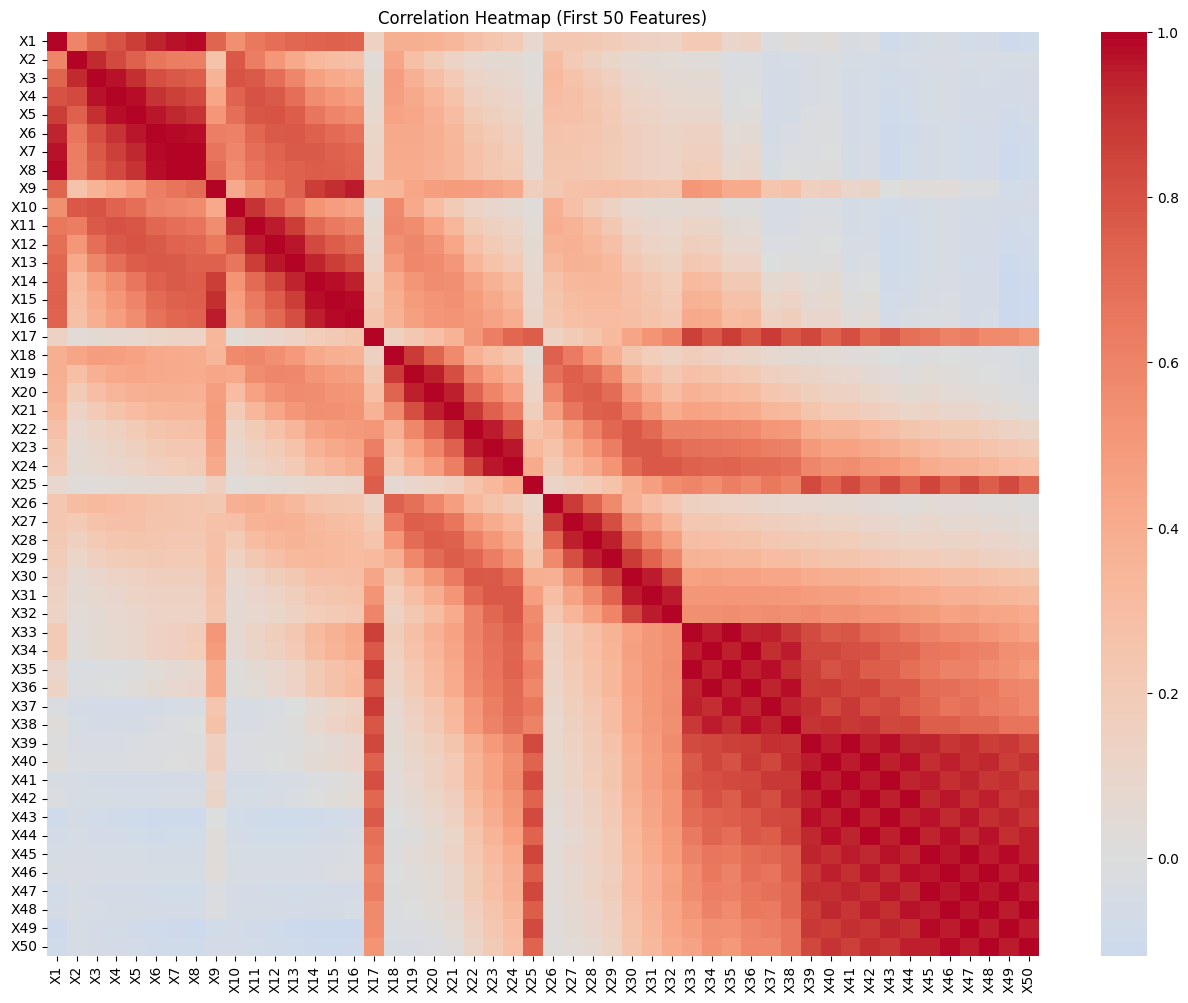

In [7]:
# correlation matrix & heatmap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import time

print("Calculating correlation matrix for ALL features...")
start_time = time.time()

# Calculate correlation matrix with progress
n_features = len(feature_cols)
print(f"Processing {n_features} features...")

# Use numpy for faster calculation
data_array = train[feature_cols].values
corr_matrix = np.zeros((n_features, n_features))

print("Computing correlations with progress...")
for i in tqdm(range(n_features), desc="Processing features"):
    for j in range(i, n_features):
        if i == j:
            corr_matrix[i, j] = 1.0
        else:
            # Compute correlation manually for progress tracking
            x = data_array[:, i]
            y = data_array[:, j]
            corr = np.corrcoef(x, y)[0, 1]
            corr_matrix[i, j] = corr
            corr_matrix[j, i] = corr

# Convert to DataFrame
corr_matrix_df = pd.DataFrame(corr_matrix, index=feature_cols, columns=feature_cols)

print(f"Correlation calculation took {time.time() - start_time:.2f} seconds")

# Plot heatmap (first 50 features for visualization)
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_df.iloc[:50, :50], cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (First 50 Features)')
plt.show()

In [10]:
# highly correlated feature pairs/groups (>0.8)

high_corr_pairs = []
threshold = 0.8
total_pairs = n_features * (n_features - 1) // 2

print(f"Checking {total_pairs:,} feature pairs for correlation > {threshold}...")

for i in tqdm(range(n_features), desc="Checking correlations"):
    for j in range(i+1, n_features):
        corr = corr_matrix[i, j]  # Use numpy array indexing instead of .iloc
        if abs(corr) > threshold:
            high_corr_pairs.append((feature_cols[i], feature_cols[j], corr))

print(f"Found {len(high_corr_pairs)} highly correlated pairs")

# Show top correlations
for pair in high_corr_pairs[:10]:
    print(f"{pair[0]} & {pair[1]}: corr={pair[2]:.3f}")

# Group features by correlation
from collections import defaultdict
grouped = defaultdict(set)
for f1, f2, corr in high_corr_pairs:
    grouped[f1].add(f2)
    grouped[f2].add(f1)
print(f"Number of correlated feature groups: {len(grouped)}")

# Show the largest correlation groups
print("\nLargest correlation groups:")
group_sizes = [(len(group), features) for features, group in grouped.items()]
group_sizes.sort(reverse=True)
for size, features in group_sizes[:5]:
    print(f"Group with {size} features: {features}")

Checking 303,810 feature pairs for correlation > 0.8...


Checking correlations: 100%|██████████| 780/780 [00:00<00:00, 6631.16it/s]

Found 2270 highly correlated pairs
X1 & X4: corr=0.802
X1 & X5: corr=0.867
X1 & X6: corr=0.940
X1 & X7: corr=0.967
X1 & X8: corr=0.983
X2 & X3: corr=0.923
X2 & X4: corr=0.833
X3 & X4: corr=0.973
X3 & X5: corr=0.911
X3 & X6: corr=0.815
Number of correlated feature groups: 724

Largest correlation groups:
Group with 24 features: X290
Group with 24 features: X288
Group with 23 features: X39
Group with 23 features: X286
Group with 22 features: X41


,min,max,mean,std,25%,50%,75%
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,-12.842425,16.682129,-0.004215,0.922670,-0.344668,-0.037081,0.317137
std,16.037931,28.183330,0.132305,0.162779,0.228317,0.171243,0.261207
min,-156.774956,1.522945,-0.779938,0.359641,-1.315535,-1.061609,-0.548217
25%,-13.738736,6.171888,-0.014576,0.826387,-0.476437,-0.042225,0.148399
50%,-8.714234,9.300256,-0.000485,0.921770,-0.322389,-0.000878,0.315919
75%,-5.773244,14.584017,0.022115,1.019223,-0.179719,0.026331,0.472002
max,-0.049987,275.926158,0.734581,1.433086,0.057745,0.663388,1.392614


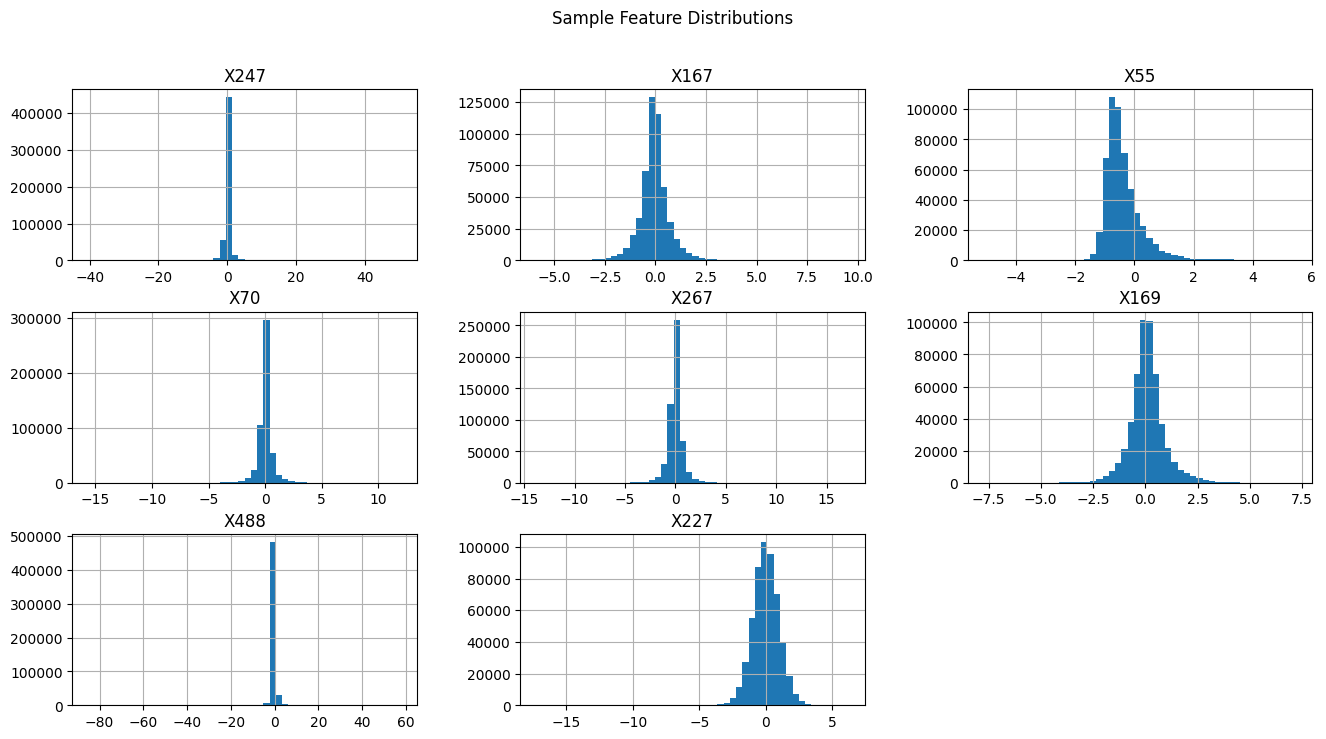

In [11]:
# feature distribution & ranges

feature_stats = []
for col in feature_cols:
    s = train[col]
    feature_stats.append({
        'feature': col,
        'min': s.min(),
        'max': s.max(),
        'mean': s.mean(),
        'std': s.std(),
        '25%': s.quantile(0.25),
        '50%': s.quantile(0.5),
        '75%': s.quantile(0.75)
    })
feature_stats_df = pd.DataFrame(feature_stats)

# Show summary
display(feature_stats_df.describe())

# Plot distributions for a sample of features
sampled = np.random.choice(feature_cols, 8, replace=False)
train[sampled].hist(bins=50, figsize=(16, 8))
plt.suptitle('Sample Feature Distributions')
plt.show()

Cluster centers (standardized):
[[ 2.07760435e+00 -5.01491168e-02  4.80932461e-01 -3.10238627e-01
   3.82751834e-01  1.42544225e+00  1.52182345e+00]
 [ 1.37694905e-01  4.32817439e-01  3.49026031e-01 -2.78478424e-01
  -8.40962918e-01 -1.52060024e-03  8.60558777e-01]
 [ 2.55583203e-02 -2.41084087e-01 -7.42114099e-03 -1.17009528e-01
   5.41819039e-01  1.70950780e-01 -3.44010906e-01]
 [ 1.29146330e-01  1.65769431e+00 -2.76663330e+00  3.26627808e+00
   9.86402154e-01  1.79260864e-01 -8.08423640e-01]
 [-2.53552469e+00 -1.30331397e+00  4.54146730e-01 -3.47999589e-01
  -1.68163154e+00 -2.57584386e+00 -1.56827198e+00]]


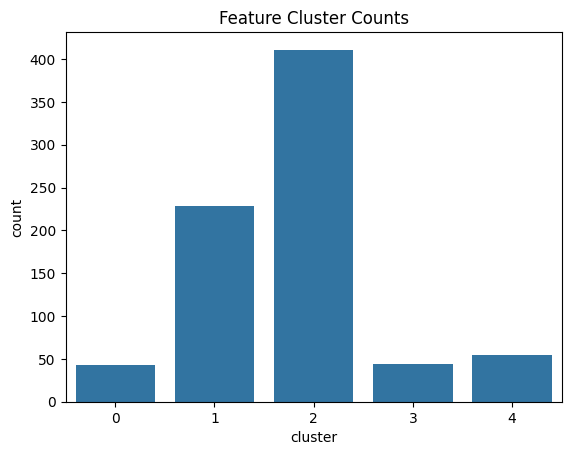

In [13]:
# clustering feature by distribution

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# based on their distributional statistics
X_cluster = feature_stats_df[['mean', 'std', 'min', 'max', '25%', '50%', '75%']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
feature_stats_df['cluster'] = clusters

# Show cluster centers
print('Cluster centers (standardized):')
print(kmeans.cluster_centers_)

# Plot cluster assignments
sns.countplot(x='cluster', data=feature_stats_df)
plt.title('Feature Cluster Counts')
plt.show()

Clusters: 2, Silhouette Score: 0.480
Clusters: 3, Silhouette Score: 0.395
Clusters: 4, Silhouette Score: 0.303
Clusters: 5, Silhouette Score: 0.304
Clusters: 6, Silhouette Score: 0.282
Clusters: 7, Silhouette Score: 0.293
Clusters: 8, Silhouette Score: 0.302
Clusters: 9, Silhouette Score: 0.310
Clusters: 10, Silhouette Score: 0.315


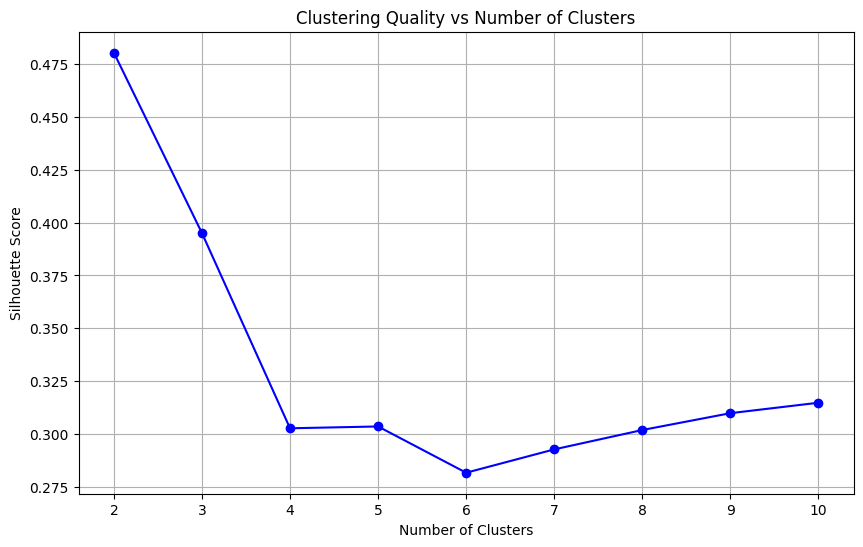

Optimal number of clusters: 2


In [14]:
## test different numbers of clusters

from sklearn.metrics import silhouette_score
import numpy as np

# Test different numbers of clusters
cluster_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    cluster_scores.append(score)
    print(f"Clusters: {n_clusters}, Silhouette Score: {score:.3f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, cluster_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Clustering Quality vs Number of Clusters')
plt.grid(True)
plt.show()

# Find optimal number
optimal_clusters = cluster_range[np.argmax(cluster_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

In [15]:

# Features with highest and lowest std deviation (volatility patterns)
top_vol = feature_stats_df.sort_values('std', ascending=False).head(5)
low_vol = feature_stats_df.sort_values('std', ascending=True).head(5)
print('Most volatile features:')
display(top_vol)
print('Least volatile features:')
display(low_vol)

Most volatile features:


,feature,min,max,mean,std,25%,50%,75%,cluster
543,X544,-0.099119,275.926158,0.051867,1.433086,-0.097677,-0.090535,-0.030557,3
531,X532,-0.049987,238.404726,0.026495,1.410273,-0.049878,-0.049301,-0.043050,3
594,X595,-115.396181,117.490973,0.001287,1.389529,0.000574,0.001800,0.003306,3
597,X598,-71.406682,70.751262,0.002287,1.385252,-0.000835,0.003133,0.007352,3
600,X601,-52.305403,50.673996,0.003364,1.380582,-0.002920,0.004297,0.010614,3


Least volatile features:


,feature,min,max,mean,std,25%,50%,75%,cluster
188,X189,-4.777357,6.781245,-0.097783,0.359641,-0.265556,-0.110951,0.056452,2
185,X186,-6.770941,8.301117,-0.111931,0.385341,-0.258166,-0.134133,0.006306,2
182,X183,-6.306991,7.516532,-0.122522,0.391022,-0.254013,-0.154839,-0.038671,2
190,X191,-3.388417,3.151537,-0.249519,0.394189,-0.477780,-0.268007,-0.034522,4
187,X188,-3.400125,3.168445,-0.249043,0.399592,-0.479277,-0.274805,-0.027518,4


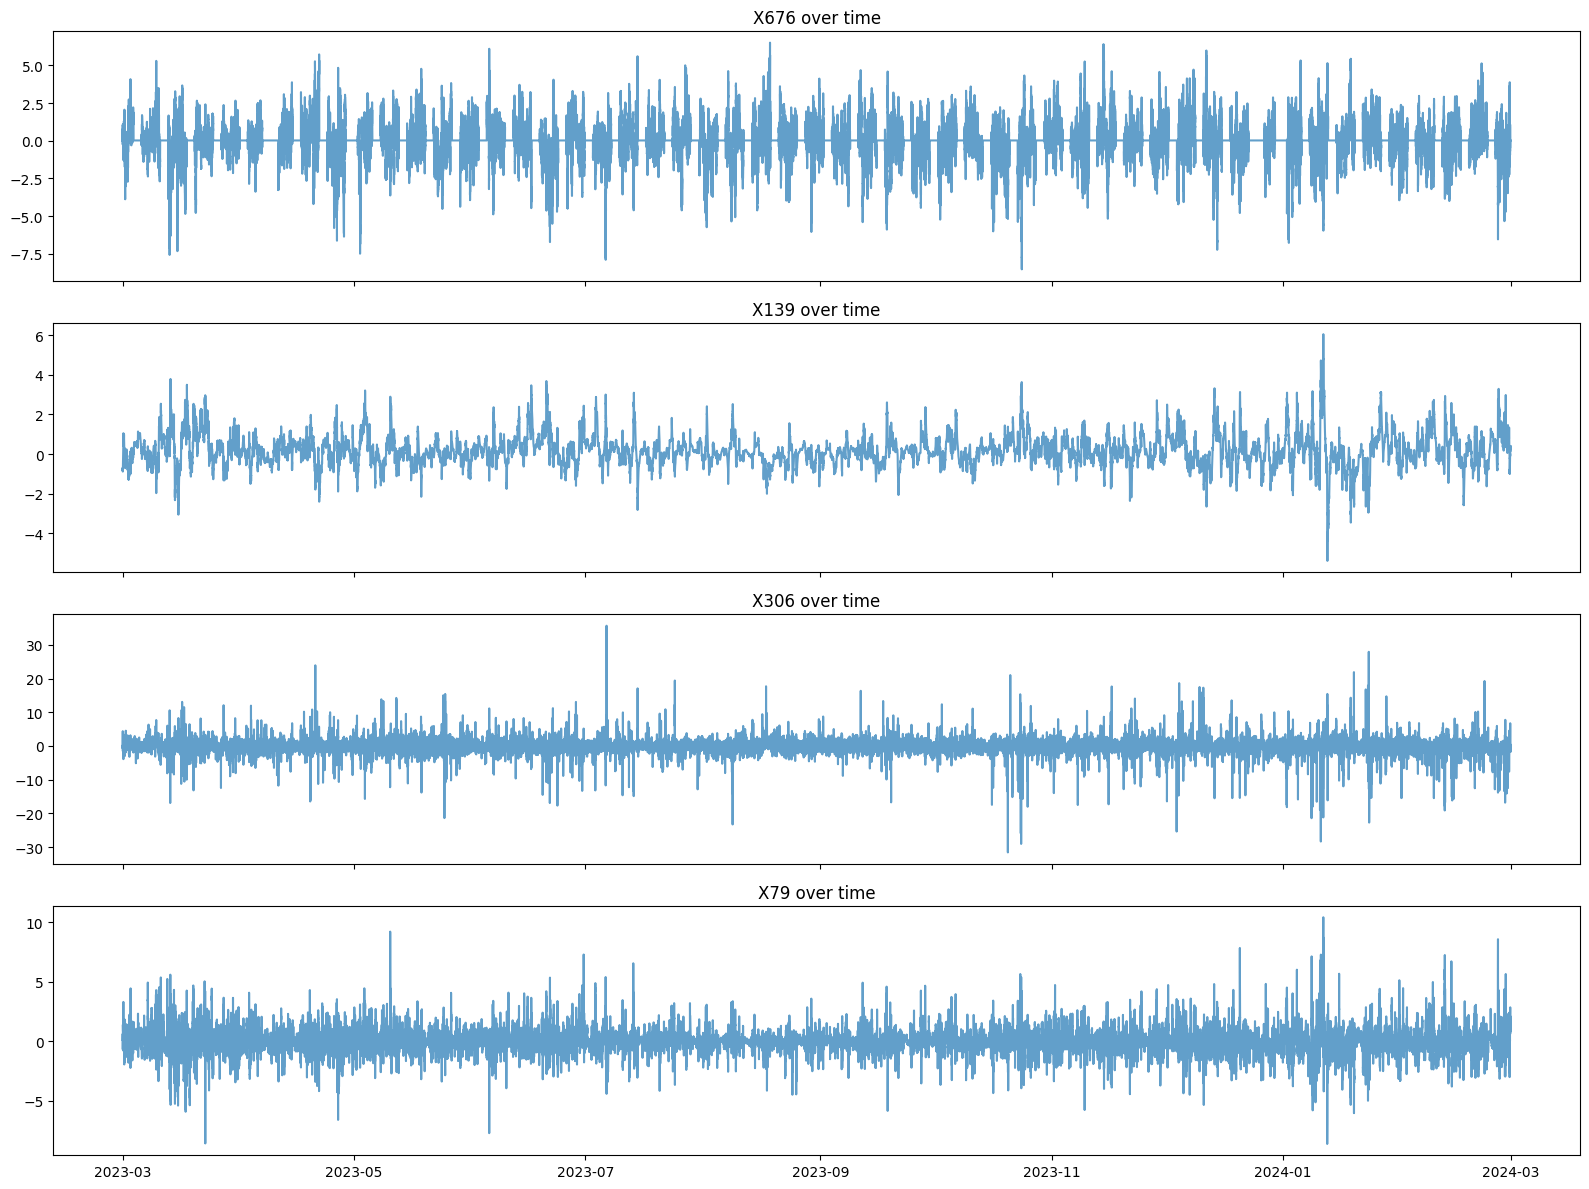

In [16]:
# Plot how a few features evolve over time
sampled = np.random.choice(feature_cols, 4, replace=False)
fig, axs = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
for i, col in enumerate(sampled):
    axs[i].plot(train.index, train[col], alpha=0.7)
    axs[i].set_title(f'{col} over time')
plt.tight_layout()
plt.show()

In [17]:
# since time evolution only showed a few feature
# stats analysis of all features

# Analyze temporal patterns for ALL features (no plotting)
print("Analyzing temporal patterns for all 780 features...")

temporal_stats = []
for col in tqdm(feature_cols, desc="Analyzing features"):
    feature_data = train[col]

    # Calculate temporal statistics
    temporal_stats.append({
        'feature': col,
        'mean': feature_data.mean(),
        'std': feature_data.std(),
        'trend': np.polyfit(range(len(feature_data)), feature_data, 1)[0],  # Linear trend
        'autocorr': feature_data.autocorr(),  # Temporal correlation
        'volatility': feature_data.rolling(100).std().mean(),  # Rolling volatility
        'spikes': (abs(feature_data) > 3 * feature_data.std()).sum()  # Number of spikes
    })

temporal_df = pd.DataFrame(temporal_stats)

# Show summary of temporal patterns
print("\nTemporal patterns summary:")
print(temporal_df.describe())

# Find features with strongest temporal patterns
print("\nFeatures with strongest trends:")
print(temporal_df.nlargest(10, 'trend')[['feature', 'trend']])

print("\nFeatures with highest autocorrelation:")
print(temporal_df.nlargest(10, 'autocorr')[['feature', 'autocorr']])

print("\nFeatures with most spikes:")
print(temporal_df.nlargest(10, 'spikes')[['feature', 'spikes']])

Analyzing temporal patterns for all 780 features...


Analyzing features: 100%|██████████| 780/780 [01:19<00:00,  9.79it/s]


Temporal patterns summary:
             mean         std         trend    autocorr  volatility  \
count  780.000000  780.000000  7.800000e+02  780.000000  780.000000   
mean    -0.004215    0.922670  1.340522e-07    0.945772    0.343324   
std      0.132305    0.162779  6.001136e-07    0.117782    0.221095   
min     -0.779938    0.359641 -2.637303e-06   -0.078607    0.018760   
25%     -0.014576    0.826387 -6.509430e-08    0.942854    0.146317   
50%     -0.000485    0.921770  6.712624e-09    0.988588    0.308974   
75%      0.022115    1.019223  2.455606e-07    0.998158    0.521370   
max      0.734581    1.433086  3.817103e-06    1.000000    0.965952   

             spikes  
count    780.000000  
mean    8801.192308  
std     3337.584725  
min        0.000000  
25%     6983.000000  
50%     9505.500000  
75%    11059.000000  
max    23509.000000  

Features with strongest trends:
    feature     trend
590    X591  0.000004
581    X582  0.000004
578    X579  0.000004
569    X570  

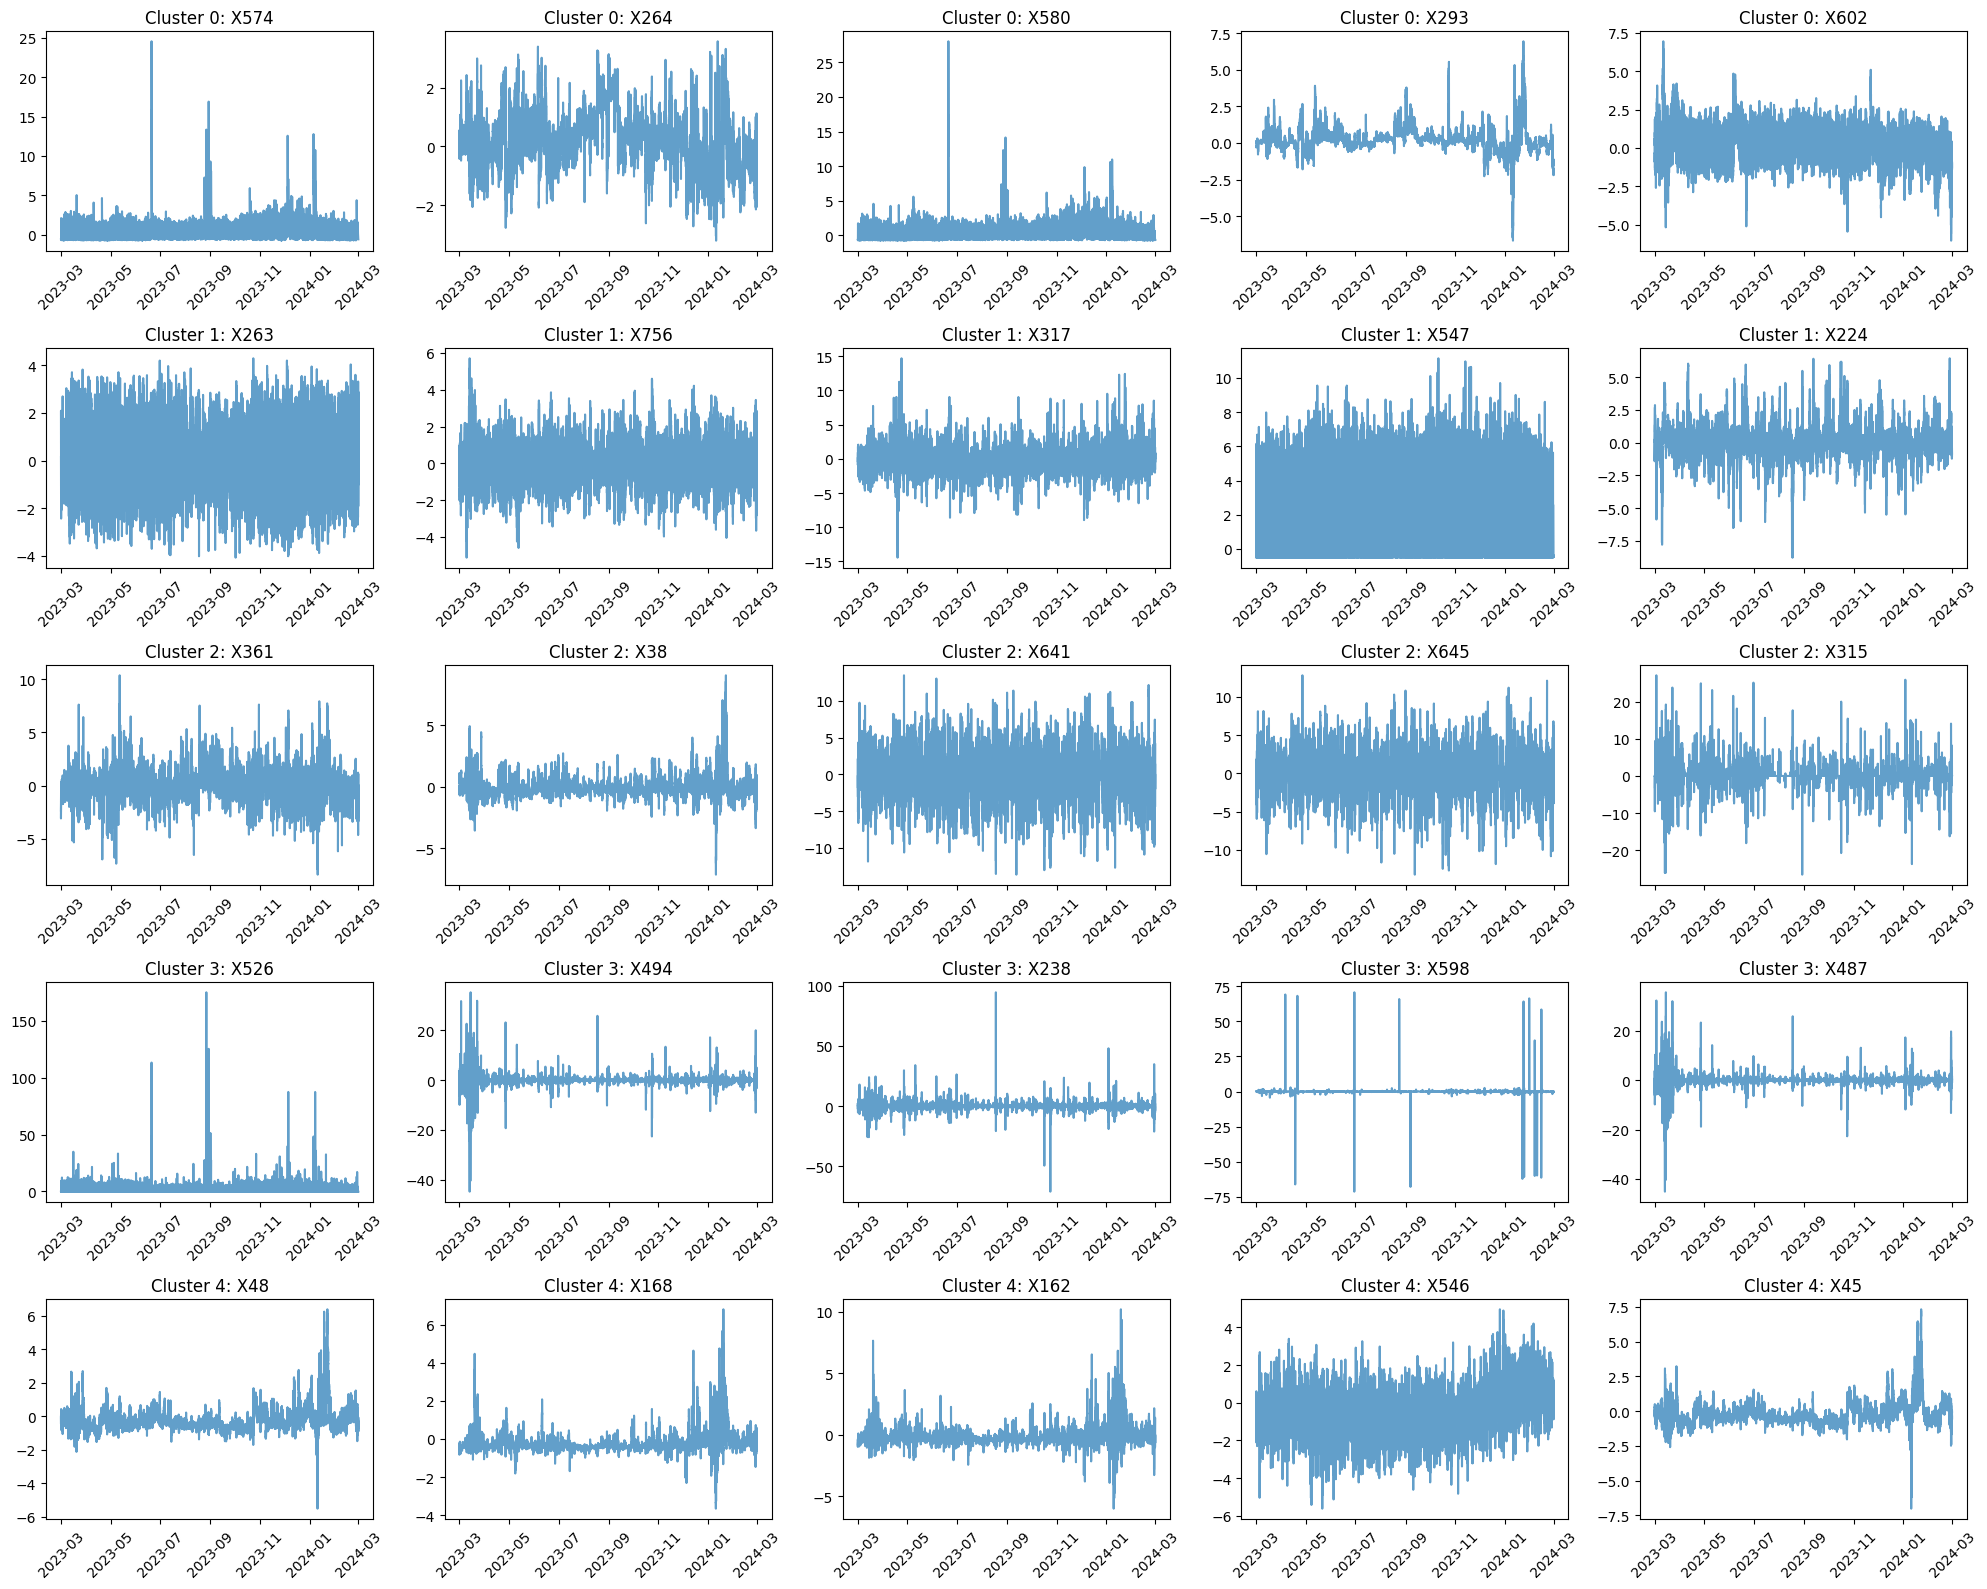

Showed 5 features from each of the 5 clusters (25 total features)


In [18]:
# since time evolution only showed a few feature
# stratified sampling by cluster

# Sample features from each cluster (more representative)
features_by_cluster = {}
for cluster_id in range(5):
    cluster_features = feature_stats_df[feature_stats_df['cluster'] == cluster_id]['feature'].tolist()
    # Sample 3-5 features from each cluster
    sampled_features = np.random.choice(cluster_features, min(5, len(cluster_features)), replace=False)
    features_by_cluster[cluster_id] = sampled_features

# Plot features from each cluster
fig, axes = plt.subplots(5, 5, figsize=(20, 16))
for cluster_id in range(5):
    for i, feature in enumerate(features_by_cluster[cluster_id]):
        if i < 5:  # Limit to 5 features per cluster
            axes[cluster_id, i].plot(train.index, train[feature], alpha=0.7)
            axes[cluster_id, i].set_title(f'Cluster {cluster_id}: {feature}')
            axes[cluster_id, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Showed 5 features from each of the 5 clusters (25 total features)")

In [19]:
# since time evolution only showed a few feature
# categorize feature types

# Classify features by temporal behavior
def classify_temporal_pattern(row):
    if abs(row['trend']) > 0.001:
        return 'Trending'
    elif row['autocorr'] > 0.5:
        return 'Cyclical'
    elif row['spikes'] > 100:
        return 'Spiky'
    elif row['volatility'] > row['std'] * 0.5:
        return 'Volatile'
    else:
        return 'Stable'

temporal_df['temporal_type'] = temporal_df.apply(classify_temporal_pattern, axis=1)

print("\nTemporal pattern classification:")
print(temporal_df['temporal_type'].value_counts())

# Show examples of each type
for pattern_type in temporal_df['temporal_type'].unique():
    examples = temporal_df[temporal_df['temporal_type'] == pattern_type]['feature'].head(3)
    print(f"\n{pattern_type} features: {list(examples)}")

# Merge with cluster information
temporal_df['cluster'] = temporal_df['feature'].map(feature_stats_df.set_index('feature')['cluster'])
print("\nTemporal patterns by cluster:")
print(temporal_df.groupby(['temporal_type', 'cluster']).size())


Temporal pattern classification:
temporal_type
Cyclical    770
Spiky        10
Name: count, dtype: int64

Cyclical features: ['X1', 'X2', 'X3']

Spiky features: ['X234', 'X235', 'X241']

Temporal patterns by cluster:
temporal_type  cluster
Cyclical       0           43
               1          228
               2          411
               3           34
               4           54
Spiky          3           10
dtype: int64


In [20]:
# feature hypothesis table

def feature_hypothesis(row):
    if 0 <= row['min'] and row['max'] <= 100:
        return 'Possible technical indicator (e.g., RSI)'
    elif abs(row['mean']) < 0.1 and abs(row['min']) < 2 and abs(row['max']) < 2:
        return 'Possible return/change'
    elif row['std'] > 5 or abs(row['max']) > 100:
        return 'Possible price/volume'
    elif row['cluster'] in top_vol['cluster'].values:
        return 'Very volatile - maybe price or volume'
    elif row['cluster'] in low_vol['cluster'].values:
        return 'Stable - maybe indicator or normalized'
    else:
        return 'Unknown/other'

feature_stats_df['hypothesis'] = feature_stats_df.apply(feature_hypothesis, axis=1)
display(feature_stats_df[['feature', 'min', 'max', 'mean', 'std', 'cluster', 'hypothesis']].head(20))

,feature,min,max,mean,std,cluster,hypothesis
0,X1,-4.746617,5.013179,-0.033823,0.912125,1,Unknown/other
1,X2,-8.953153,9.395434,-0.000269,0.937410,1,Unknown/other
2,X3,-7.410052,7.849541,-0.000307,0.933608,1,Unknown/other
3,X4,-6.615129,6.941699,-0.000318,0.930464,1,Unknown/other
4,X5,-5.699821,6.358501,-0.000339,0.927752,1,Unknown/other
5,X6,-4.894858,5.722127,-0.000431,0.923046,1,Unknown/other
6,X7,-4.775148,5.381167,-0.000534,0.919970,1,Unknown/other
7,X8,-4.818232,5.155555,-0.000703,0.918019,1,Unknown/other
8,X9,-4.645874,4.580035,-0.037028,0.888543,1,Unknown/other
9,X10,-10.652836,10.454863,-0.000165,0.891078,1,Unknown/other


In [26]:
## full table stored /content/feature_hypothesis_table.csv

feature_stats_df[['feature', 'min', 'max', 'mean', 'std', 'cluster', 'hypothesis']].to_csv('feature_hypothesis_table.csv', index=False)

from google.colab import files
files.download('feature_hypothesis_table.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# summary table for each feature (name, hypothesis of what type, mean std min max)
for _, row in feature_stats_df.iterrows():
    print(f"{row['feature']}: {row['hypothesis']} (mean={row['mean']:.2f}, std={row['std']:.2f}, min={row['min']:.2f}, max={row['max']:.2f})")

X1: Unknown/other (mean=-0.03, std=0.91, min=-4.75, max=5.01)
X2: Unknown/other (mean=-0.00, std=0.94, min=-8.95, max=9.40)
X3: Unknown/other (mean=-0.00, std=0.93, min=-7.41, max=7.85)
X4: Unknown/other (mean=-0.00, std=0.93, min=-6.62, max=6.94)
X5: Unknown/other (mean=-0.00, std=0.93, min=-5.70, max=6.36)
X6: Unknown/other (mean=-0.00, std=0.92, min=-4.89, max=5.72)
X7: Unknown/other (mean=-0.00, std=0.92, min=-4.78, max=5.38)
X8: Unknown/other (mean=-0.00, std=0.92, min=-4.82, max=5.16)
X9: Unknown/other (mean=-0.04, std=0.89, min=-4.65, max=4.58)
X10: Unknown/other (mean=-0.00, std=0.89, min=-10.65, max=10.45)
X11: Unknown/other (mean=-0.00, std=0.90, min=-8.18, max=8.42)
X12: Unknown/other (mean=-0.00, std=0.91, min=-6.90, max=7.01)
X13: Unknown/other (mean=-0.00, std=0.91, min=-6.13, max=6.24)
X14: Unknown/other (mean=-0.00, std=0.90, min=-5.45, max=5.23)
X15: Unknown/other (mean=-0.00, std=0.90, min=-5.12, max=4.93)
X16: Unknown/other (mean=-0.00, std=0.90, min=-4.88, max=4.85)